In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
from torch.autograd import Variable
from sklearn.utils import shuffle as skshuffle
from sklearn.metrics import roc_auc_score

In [32]:
def get_minibatches(X, mb_size, shuffle=True):
    minibatches = []
    X_shuff = np.copy(X)

    if shuffle:
        X_shuff = skshuffle(X_shuff)

    for i in range(0, X_shuff.shape[0], mb_size):
        yield X_shuff[i:i + mb_size]

def sample_negatives(X, n_e):
    M = X.shape[0]

    corr = np.random.randint(n_e, size=M)
    e_idxs = np.random.choice([0, 2], size=M)

    X_corr = np.copy(X)
    X_corr[np.arange(M), e_idxs] = corr

    return X_corr

def accuracy(y_pred, y_true, thresh=0.5, reverse=False):
    y = (y_pred >= thresh) if not reverse else (y_pred <= thresh)
    return np.mean(y == y_true)

def auc(y_pred, y_true):
    return roc_auc_score(y_true, y_pred)

In [58]:
class RESCAL(nn.Module):
    """
    RESCAL: bilinear model
    ----------------------
    Nickel, Maximilian, Volker Tresp, and Hans-Peter Kriegel.
    "A three-way model for collective learning on multi-relational data."
    ICML. 2011.
    """

    def __init__(self, n_e, n_r, k, lam, gpu=False):
        """
        RESCAL: bilinear model
        ----------------------

        Params:
        -------
            n_e: int
                Number of entities in dataset.

            n_r: int
                Number of relationships in dataset.

            k: int
                Embedding size.

            lam: float
                Prior strength of the embeddings. Used to constaint the
                embedding norms inside a (euclidean) unit ball. The prior is
                Gaussian, this param is the precision.

            gpu: bool, default: False
                Whether to use GPU or not.
        """
        super(RESCAL, self).__init__()
        self.gpu = gpu
        # Hyperparams
        self.n_e = n_e
        self.n_r = n_r
        self.k = k
        self.lam = lam

        # Nets
        self.emb_E = nn.Embedding(self.n_e, self.k)
        self.emb_R = nn.Embedding(self.n_r, self.k**2)

        self.embeddings = [self.emb_E, self.emb_R]
        self.initialize_embeddings()

        # Copy all params to GPU if specified
        if self.gpu:
            self.cuda()

    def forward(self, X):
        # Decompose X into head, relationship, tail
        hs, ls, ts = X[:, 0], X[:, 1], X[:, 2]

        if self.gpu:
            hs = Variable(torch.from_numpy(hs).cuda())
            ls = Variable(torch.from_numpy(ls).cuda())
            ts = Variable(torch.from_numpy(ts).cuda())
        else:
            hs = Variable(torch.from_numpy(hs))
            ls = Variable(torch.from_numpy(ls))
            ts = Variable(torch.from_numpy(ts))

        # Project to embedding, each is M x k
        e_hs = self.emb_E(hs).view(-1, self.k, 1)
        e_ts = self.emb_E(ts).view(-1, self.k, 1)
        W = self.emb_R(ls).view(-1, self.k, self.k)  # M x k x k

        # Forward
        out = torch.bmm(torch.transpose(e_hs, 1, 2), W)  # h^T W
        out = torch.bmm(out, e_ts)  # (h^T W) h
        out = out.view(-1, 1)  # [-1, 1, 1] -> [-1, 1]

        return out
    
    def log_loss(self, y_pred, y_true, average=True):
        """
        Compute log loss (Bernoulli NLL).

        Params:
        -------
        y_pred: vector of size Mx1
            Contains prediction logits.

        y_true: np.array of size Mx1 (binary)
            Contains the true labels.

        average: bool, default: True
            Whether to average the loss or just summing it.

        Returns:
        --------
        loss: float
        """
        if self.gpu:
            y_true = Variable(torch.from_numpy(y_true.astype(np.float32)).cuda())
        else:
            y_true = Variable(torch.from_numpy(y_true.astype(np.float32)))

        nll = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='mean')

        norm_E = torch.norm(self.emb_E.weight, 2, 1)
        norm_R = torch.norm(self.emb_R.weight, 2, 1)

        # Penalize when embeddings norms larger than one
        nlp1 = torch.sum(torch.clamp(norm_E - 1, min=0)).unsqueeze(0)
        nlp2 = torch.sum(torch.clamp(norm_R - 1, min=0)).unsqueeze(0)
        
        if average:
            nlp1 /= nlp1.size(0)
            nlp2 /= nlp2.size(0)

        return nll + self.lam*nlp1 + self.lam*nlp2  
    
    def predict(self, X, sigmoid=False):
        """
        Predict the score of test batch.

        Params:
        -------
        X: int matrix of M x 3, where M is the (mini)batch size
            First row contains index of head entities.
            Second row contains index of relationships.
            Third row contains index of tail entities.

        sigmoid: bool, default: False
            Whether to apply sigmoid at the prediction or not. Useful if the
            predicted result is scores/logits.

        Returns:
        --------
        y_pred: np.array of Mx1
        """
        sigm = nn.Sigmoid()
        y_pred = self.forward(X).view(-1, 1)

        if sigmoid:
            y_pred = sigm(y_pred)

        if self.gpu:
            return y_pred.cpu().data.numpy()
        else:
            return y_pred.data.numpy()
        
    def normalize_embeddings(self):
        for e in self.embeddings:
            e.weight.data.renorm_(p=2, dim=0, maxnorm=1)
            
    def initialize_embeddings(self):
        r = 6/np.sqrt(self.k)
        for e in self.embeddings:
            e.weight.data.uniform_(-r, r)

        self.normalize_embeddings()
    
    def get_embeddings(self):
        entity_embedding = self.embeddings[0].weight.data.numpy()
        relation_embedding = self.embeddings[1].weight.data.numpy()
        return entity_embedding, relation_embedding

In [59]:
# Set random seed
randseed = 9999
np.random.seed(randseed)
torch.manual_seed(randseed)

In [60]:
# Data Loading
# Load dictionary lookups
idx2ent = np.load('data/kinship/bin/idx2ent.npy')
idx2rel = np.load('data/kinship/bin/idx2rel.npy')

n_e = len(idx2ent)
n_r = len(idx2rel)

# Load dataset
X_train = np.load('data/kinship/bin/train.npy')
X_val = np.load('data/kinship/bin/val.npy')
y_val = np.load('data/kinship/bin/y_val.npy')

X_val_pos = X_val[y_val.ravel() == 1, :]  # Take only positive samples

M_train = X_train.shape[0]
M_val = X_val.shape[0]

# Model Parameters
k = 50
embeddings_lambda = 0
model = RESCAL(n_e=n_e, n_r=n_r, k=k, lam=embeddings_lambda, gpu= False)

In [61]:
normalize_embed = True
C = 10 # Negative Samples
n_epoch = 20
lr = 0.1
lr_decay_every = 20
#weight_decay = 1e-4
mb_size = 100  # 2x with negative sampling
print_every = 100
# Optimizer Initialization
#solver = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
solver = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
act_func = nn.Sigmoid()
# Begin training
for epoch in range(n_epoch):
    print('Epoch-{}'.format(epoch+1))
    print('----------------')
    it = 0
    # Shuffle and chunk data into minibatches
    mb_iter = get_minibatches(X_train, mb_size, shuffle=True)

    # Anneal learning rate
    lr = lr * (0.5 ** (epoch // lr_decay_every))
    for param_group in solver.param_groups:
        param_group['lr'] = lr

    for X_mb in mb_iter:
        start = time()

        # Build batch with negative sampling
        m = X_mb.shape[0]
        # C x M negative samples
        X_neg_mb = sample_negatives(X_mb, n_e)
        X_train_mb = np.vstack([X_mb, X_neg_mb])

        y_true_mb = np.vstack([np.ones([m, 1]), np.zeros([m, 1])])

        # Training step
        y = model.forward(X_train_mb)
        loss = model.log_loss(y, y_true_mb, average=True)
        loss.backward()
        solver.step()
        solver.zero_grad()
        if normalize_embed:
            model.normalize_embeddings()

        end = time()
        # Training logs
        if it % print_every == 0:
            # Training auc
            pred = model.predict(X_train_mb, sigmoid=True)
            train_acc = auc(pred, y_true_mb)
            
            # Per class accuracy
            # pos_acc = accuracy(pred[:m], y_true_mb[:m])
            # neg_acc = accuracy(pred[m:], y_true_mb[m:])

            # Validation auc
            y_pred_val = model.forward(X_val)
            y_prob_val = act_func(y_pred_val)
            
            val_acc = auc(y_prob_val.data.numpy(), y_val)
            # Validation loss
            val_loss = model.log_loss(y_pred_val, y_val, True)

            print('Iter-{}; loss: {:.4f}; train_auc: {:.4f}; val_auc: {:.4f}; val_loss: {:.4f}; time per batch: {:.2f}s'
                    .format(it, loss.data[0], train_acc, val_acc, val_loss.data[0], end-start))

        it += 1

Epoch-1
----------------
Iter-0; loss: 0.6929; train_auc: 0.4984; val_auc: 0.5043; val_loss: 0.6932; time per batch: 0.02s
Epoch-2
----------------
Iter-0; loss: 0.6927; train_auc: 0.5354; val_auc: 0.5052; val_loss: 0.6932; time per batch: 0.02s
Epoch-3
----------------
Iter-0; loss: 0.6926; train_auc: 0.5525; val_auc: 0.5050; val_loss: 0.6932; time per batch: 0.03s
Epoch-4
----------------
Iter-0; loss: 0.6920; train_auc: 0.5832; val_auc: 0.5054; val_loss: 0.6932; time per batch: 0.03s
Epoch-5
----------------
Iter-0; loss: 0.6908; train_auc: 0.6431; val_auc: 0.5108; val_loss: 0.6931; time per batch: 0.02s
Epoch-6
----------------
Iter-0; loss: 0.6899; train_auc: 0.6727; val_auc: 0.5184; val_loss: 0.6930; time per batch: 0.02s
Epoch-7
----------------
Iter-0; loss: 0.6898; train_auc: 0.6636; val_auc: 0.5300; val_loss: 0.6927; time per batch: 0.03s
Epoch-8
----------------
Iter-0; loss: 0.6894; train_auc: 0.6890; val_auc: 0.5500; val_loss: 0.6923; time per batch: 0.03s
Epoch-9
--------

In [62]:
entity_embedding, relation_embedding = model.get_embeddings()

In [64]:
entity_embedding, relation_embedding

(array([[ 0.19046573, -0.24831256,  0.14665966, ...,  0.0051994 ,
          0.23626441,  0.20533168],
        [-0.02195207, -0.14481546,  0.00521847, ...,  0.0118028 ,
          0.15299565, -0.00339364],
        [ 0.03419591,  0.22134429, -0.07165182, ..., -0.00971326,
         -0.1378213 , -0.22741874],
        ...,
        [-0.00441023,  0.09881721,  0.22227971, ..., -0.23410249,
         -0.00936928, -0.1533014 ],
        [-0.11788324,  0.10937518, -0.02970175, ..., -0.00390624,
          0.03130096,  0.21994837],
        [-0.14308794, -0.00674381, -0.23864774, ...,  0.11063214,
          0.11025032,  0.18311264]], dtype=float32),
 array([[ 4.6508089e-03, -1.8950835e-02,  1.2297976e-03, ...,
         -7.6297419e-03,  2.2179214e-02,  5.5967936e-05],
        [-1.7321285e-02,  2.2365838e-02, -9.6984422e-03, ...,
          2.8035937e-02,  4.8606765e-02,  5.3122532e-02],
        [ 4.8496920e-04,  1.5385617e-02, -1.2678771e-02, ...,
          2.8514996e-02,  3.5518799e-02,  4.6381630e-02]

## Visualization of Latent Representation

In this part we will use a very powerful visualization technique: T-SNE (t-Distributed stochastic neighbor embedding). T-SNE helps in visualizing embeddings in 2 or 3 dimensions. It is a nonlinear dimensionality reduction technique. It embeds high dimensional representation into lower dimension in such a way that similar objects are mapped to nearby points and distant objects are mapped to distant points. The algorithm is non linear and adapts to the underlying data, performing different transformations on different regions. It comes with a tueneable parameter perplexity which balances attention between local and global aspects of data.

For further details on algorithm refer to: 
[Visualizing Data using t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)



In [65]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_entity = tsne.fit_transform(entity_embedding)
tsne_relation = tsne.fit_transform(relation_embedding)

[t-SNE] Computing 103 nearest neighbors...
[t-SNE] Indexed 104 samples in 0.001s...
[t-SNE] Computed neighbors for 104 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 104 / 104
[t-SNE] Mean sigma: 0.652809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.416664
[t-SNE] KL divergence after 300 iterations: 0.157307
[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.001s...
[t-SNE] Computed neighbors for 26 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.125401
[t-SNE] KL divergence after 300 iterations: 0.518900


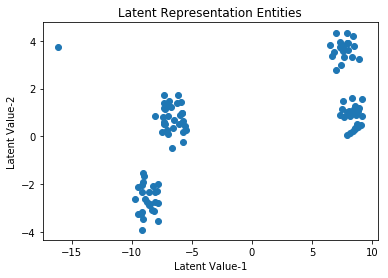

In [66]:
plt.scatter(tsne_entity[:,0],tsne_entity[:,1])
plt.xlabel('Latent Value-1')
plt.ylabel('Latent Value-2')
plt.title('Latent Representation Entities')
plt.show()

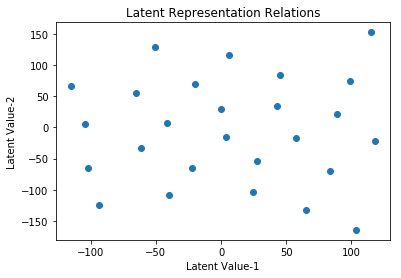

In [67]:
plt.scatter(tsne_relation[:,0],tsne_relation[:,1])
plt.xlabel('Latent Value-1')
plt.ylabel('Latent Value-2')
plt.title('Latent Representation Relations')
plt.show()

In [68]:
X_val

array([[39,  0, 80],
       [91, 23, 91],
       [77, 15, 24],
       ...,
       [ 4,  9, 76],
       [95, 17,  6],
       [40, 17, 74]], dtype=int64)

In [69]:
y_val

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [72]:
model(X_val)

tensor([[ 0.3014],
        [ 0.1912],
        [ 0.3023],
        ...,
        [-0.1173],
        [ 0.1274],
        [-0.1730]], grad_fn=<ViewBackward>)